In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from AAdam01 import AAdam
from modifiedAdam import ModifiedAdam


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   
    
class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

import numpy as np

np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

# X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# n = 2

Validation loss: 0.47147294878959656
32/32 [==============================] - 0s 613us/step


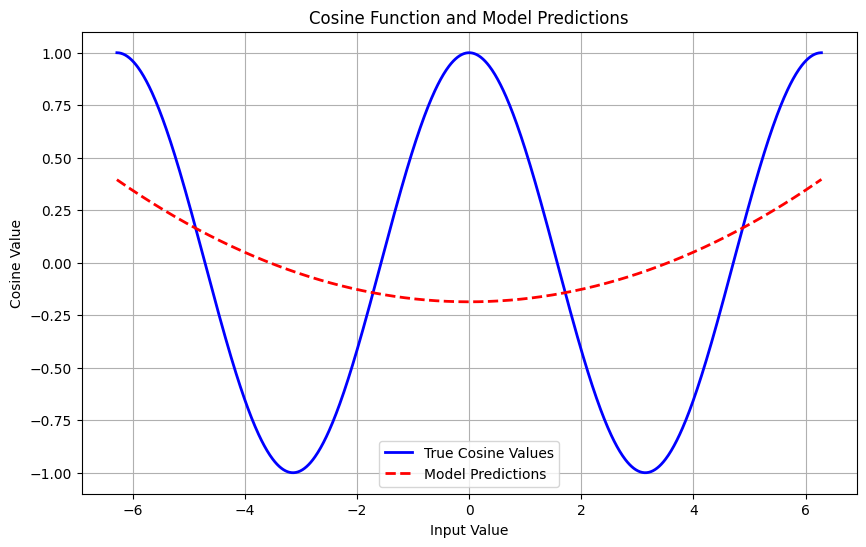

In [7]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelN2 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN2.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val))

val_loss = modelN2.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN2.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



# n = 3

Validation loss: 0.011544940061867237
32/32 [==============================] - 0s 581us/step


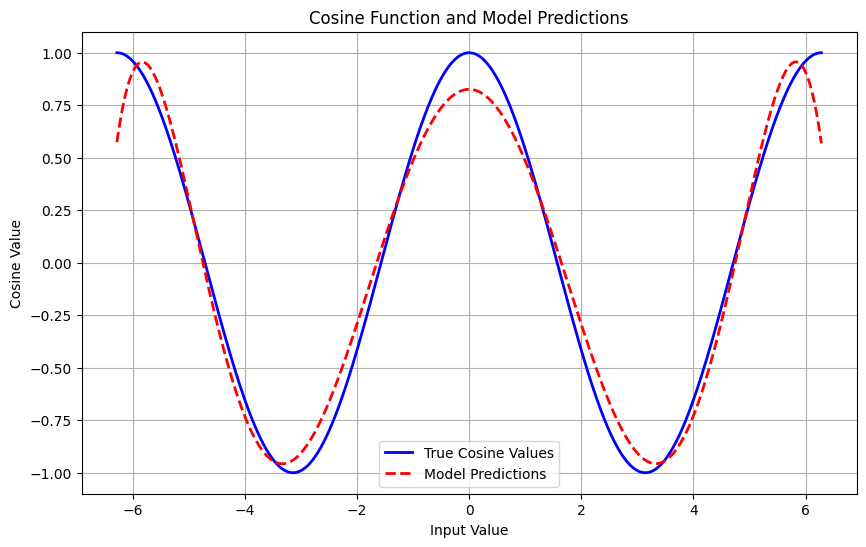

In [8]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelN3 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN3.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN3.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val))

val_loss = modelN3.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN3.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# n = 4

Epoch 1/150
158/158 [==============================] - 1s 2ms/step - loss: 0.3499 - val_loss: 0.0575
Epoch 2/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0515 - val_loss: 0.0437
Epoch 3/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0078
Epoch 4/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/150
158/158 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 2.5535e-04
Epoch 6/150
158/158 [==============================] - 0s 1ms/step - loss: 7.1730e-05 - val_loss: 3.3171e-05
Epoch 7/150
158/158 [==============================] - 0s 1ms/step - loss: 1.3365e-05 - val_loss: 3.8745e-06
Epoch 8/150
158/158 [==============================] - 0s 1ms/step - loss: 4.4058e-06 - val_loss: 1.4563e-06
Epoch 9/150
158/158 [==============================] - 0s 1ms/step - loss: 6.9608e-06 - val_loss: 6.8758e-06
Epoch 10/150
158/158 [==============================] -

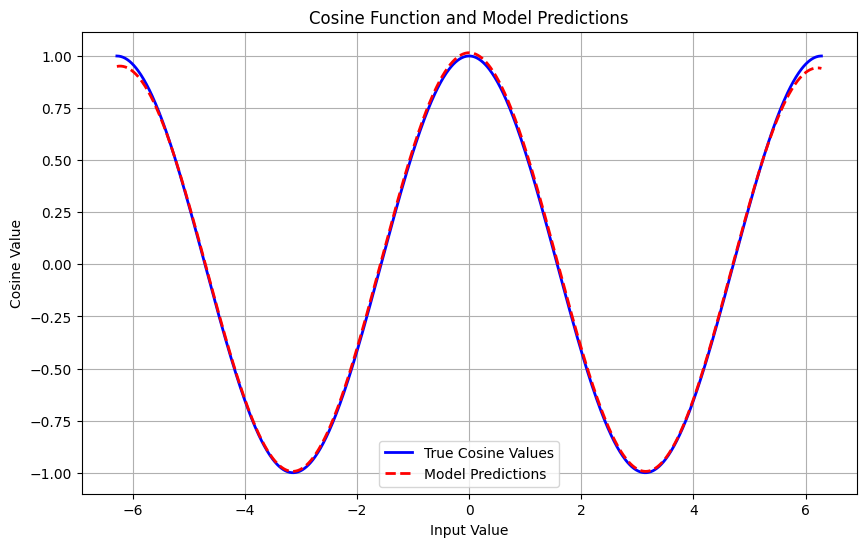

In [9]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelN4 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



# n = 5

Epoch 1/150
158/158 [==============================] - 2s 3ms/step - loss: 0.4835 - val_loss: 0.3897
Epoch 2/150
158/158 [==============================] - 0s 2ms/step - loss: 0.3995 - val_loss: 0.4977
Epoch 3/150
158/158 [==============================] - 0s 2ms/step - loss: 0.4318 - val_loss: 0.3869
Epoch 4/150
158/158 [==============================] - 0s 2ms/step - loss: 0.3748 - val_loss: 0.3675
Epoch 5/150
158/158 [==============================] - 0s 2ms/step - loss: 0.3584 - val_loss: 0.3569
Epoch 6/150
158/158 [==============================] - 0s 2ms/step - loss: 0.3701 - val_loss: 0.5037
Epoch 7/150
158/158 [==============================] - 0s 2ms/step - loss: 0.4993 - val_loss: 0.5036
Epoch 8/150
158/158 [==============================] - 0s 2ms/step - loss: 0.4991 - val_loss: 0.5033
Epoch 9/150
158/158 [==============================] - 0s 2ms/step - loss: 0.4984 - val_loss: 0.5015
Epoch 10/150
158/158 [==============================] - 0s 2ms/step - loss: 0.4829 - val_lo

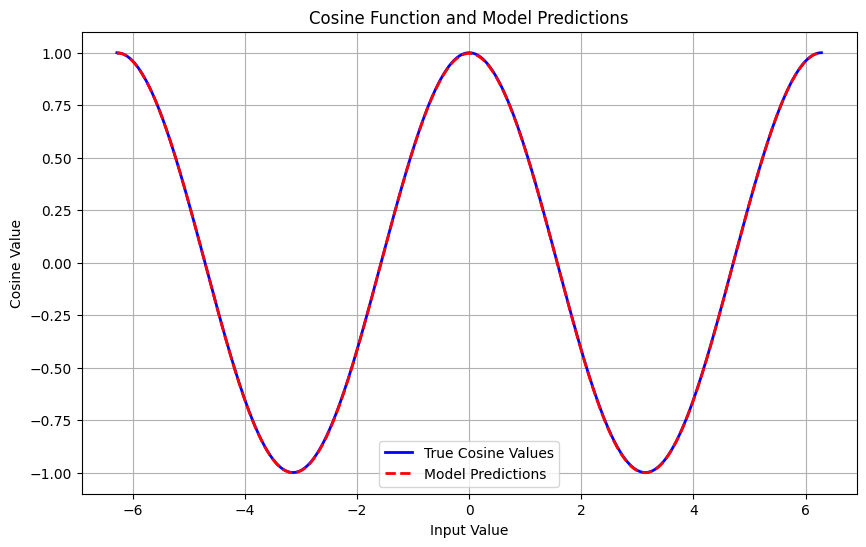

In [10]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelN5 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN5.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN5.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

val_loss = modelN5.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN5.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()



# n = 6

Epoch 1/200
158/158 [==============================] - 3s 3ms/step - loss: 0.4211 - val_loss: 0.1370
Epoch 2/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0420
Epoch 3/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0438
Epoch 4/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0350
Epoch 5/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0367
Epoch 6/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0316
Epoch 7/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0247
Epoch 8/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0262
Epoch 9/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0193
Epoch 10/200
158/158 [==============================] - 0s 2ms/step - loss: 0.0153 - val_lo

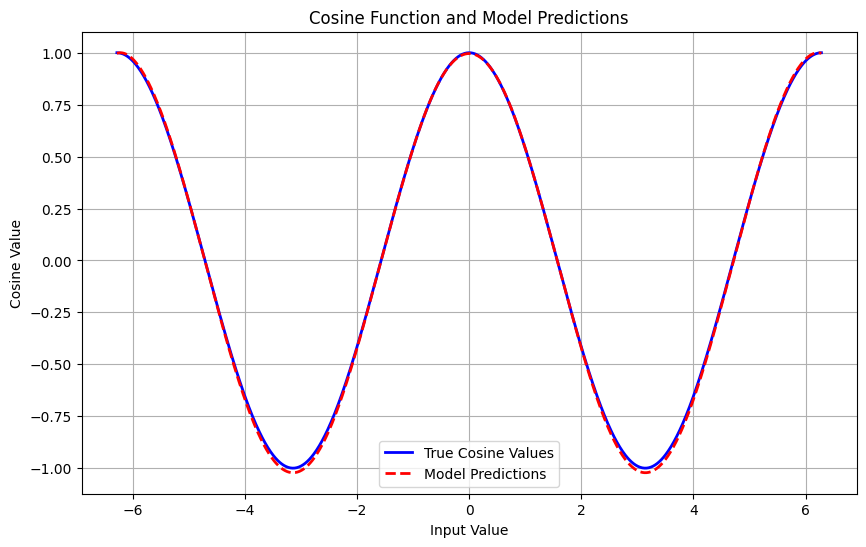

In [3]:

def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    h5 = H5Layer(h3,h4)
    h6 = H6Layer(h4,h5)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h5(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h6(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 16
modelN6 = build_model(input_shape, filters)
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN6.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 200

# n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha =  1e-2 # 0.5 #1e-2
minibatch_size = 100
n_experiment = 3

history = modelN6.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

val_loss = modelN6.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN6.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

